# Assignment 2 : Gesture Recognizer
[A2: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1199409/assignments/4176980)

Anthony Adkins

anadkins@uw.edu


In [11]:
# This cell includes the major classes used in our classification analyses
import numpy as np
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install fastdtw
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)#self.x[len(self.x) - 1])
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)#self.y[len(self.y) - 1])
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)#self.z[len(self.z) - 1])
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)#self.mag[len(self.mag) - 1])

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        #print(parsedAccelLogData)
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Accelerometer", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(logPath, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(logPath, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [13]:
# Load the data
logPath = './JonGestureLogs'
#logPath = './TonyGestureLogs'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match


## Signal processing

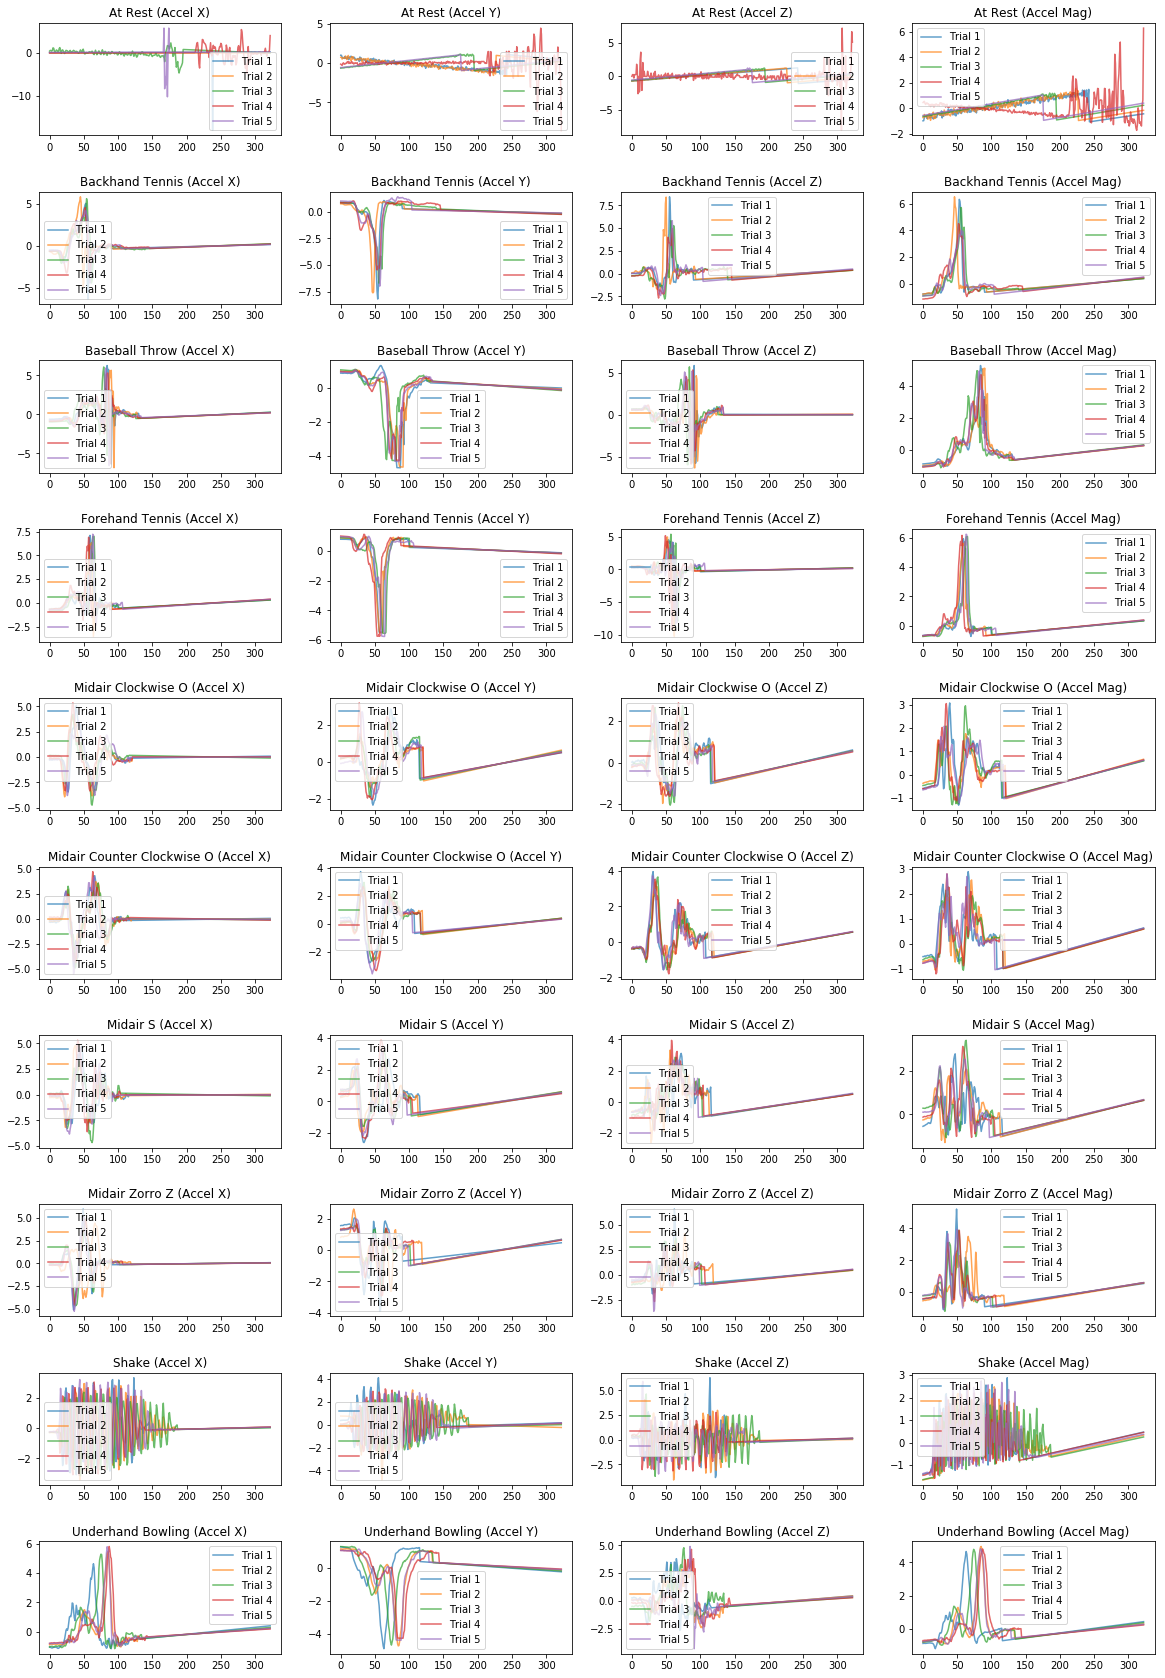

In [14]:
# Plot all the accel signals after scaling and detrending them
from scipy import signal

# define our scaling and detrending algorithm here
def scale_and_detrend( rawSig ):
    for x in range(0,len(rawSig)):
        if np.absolute(rawSig[x]) < 0.05:
            rawSig[x] = 0.0
    if(np.std(rawSig) > 0):
        scaledSig = (rawSig - np.mean(rawSig)) / np.std(rawSig)
    else:
        scaledSig = rawSig
    detrendSig = signal.detrend(scaledSig)
    return detrendSig

fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(scale_and_detrend(trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(scale_and_detrend(trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(scale_and_detrend(trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(scale_and_detrend(trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1
#fig.savefig('tonygestures.png', bbox_inches='tight')
plt.show()
plt.clf()


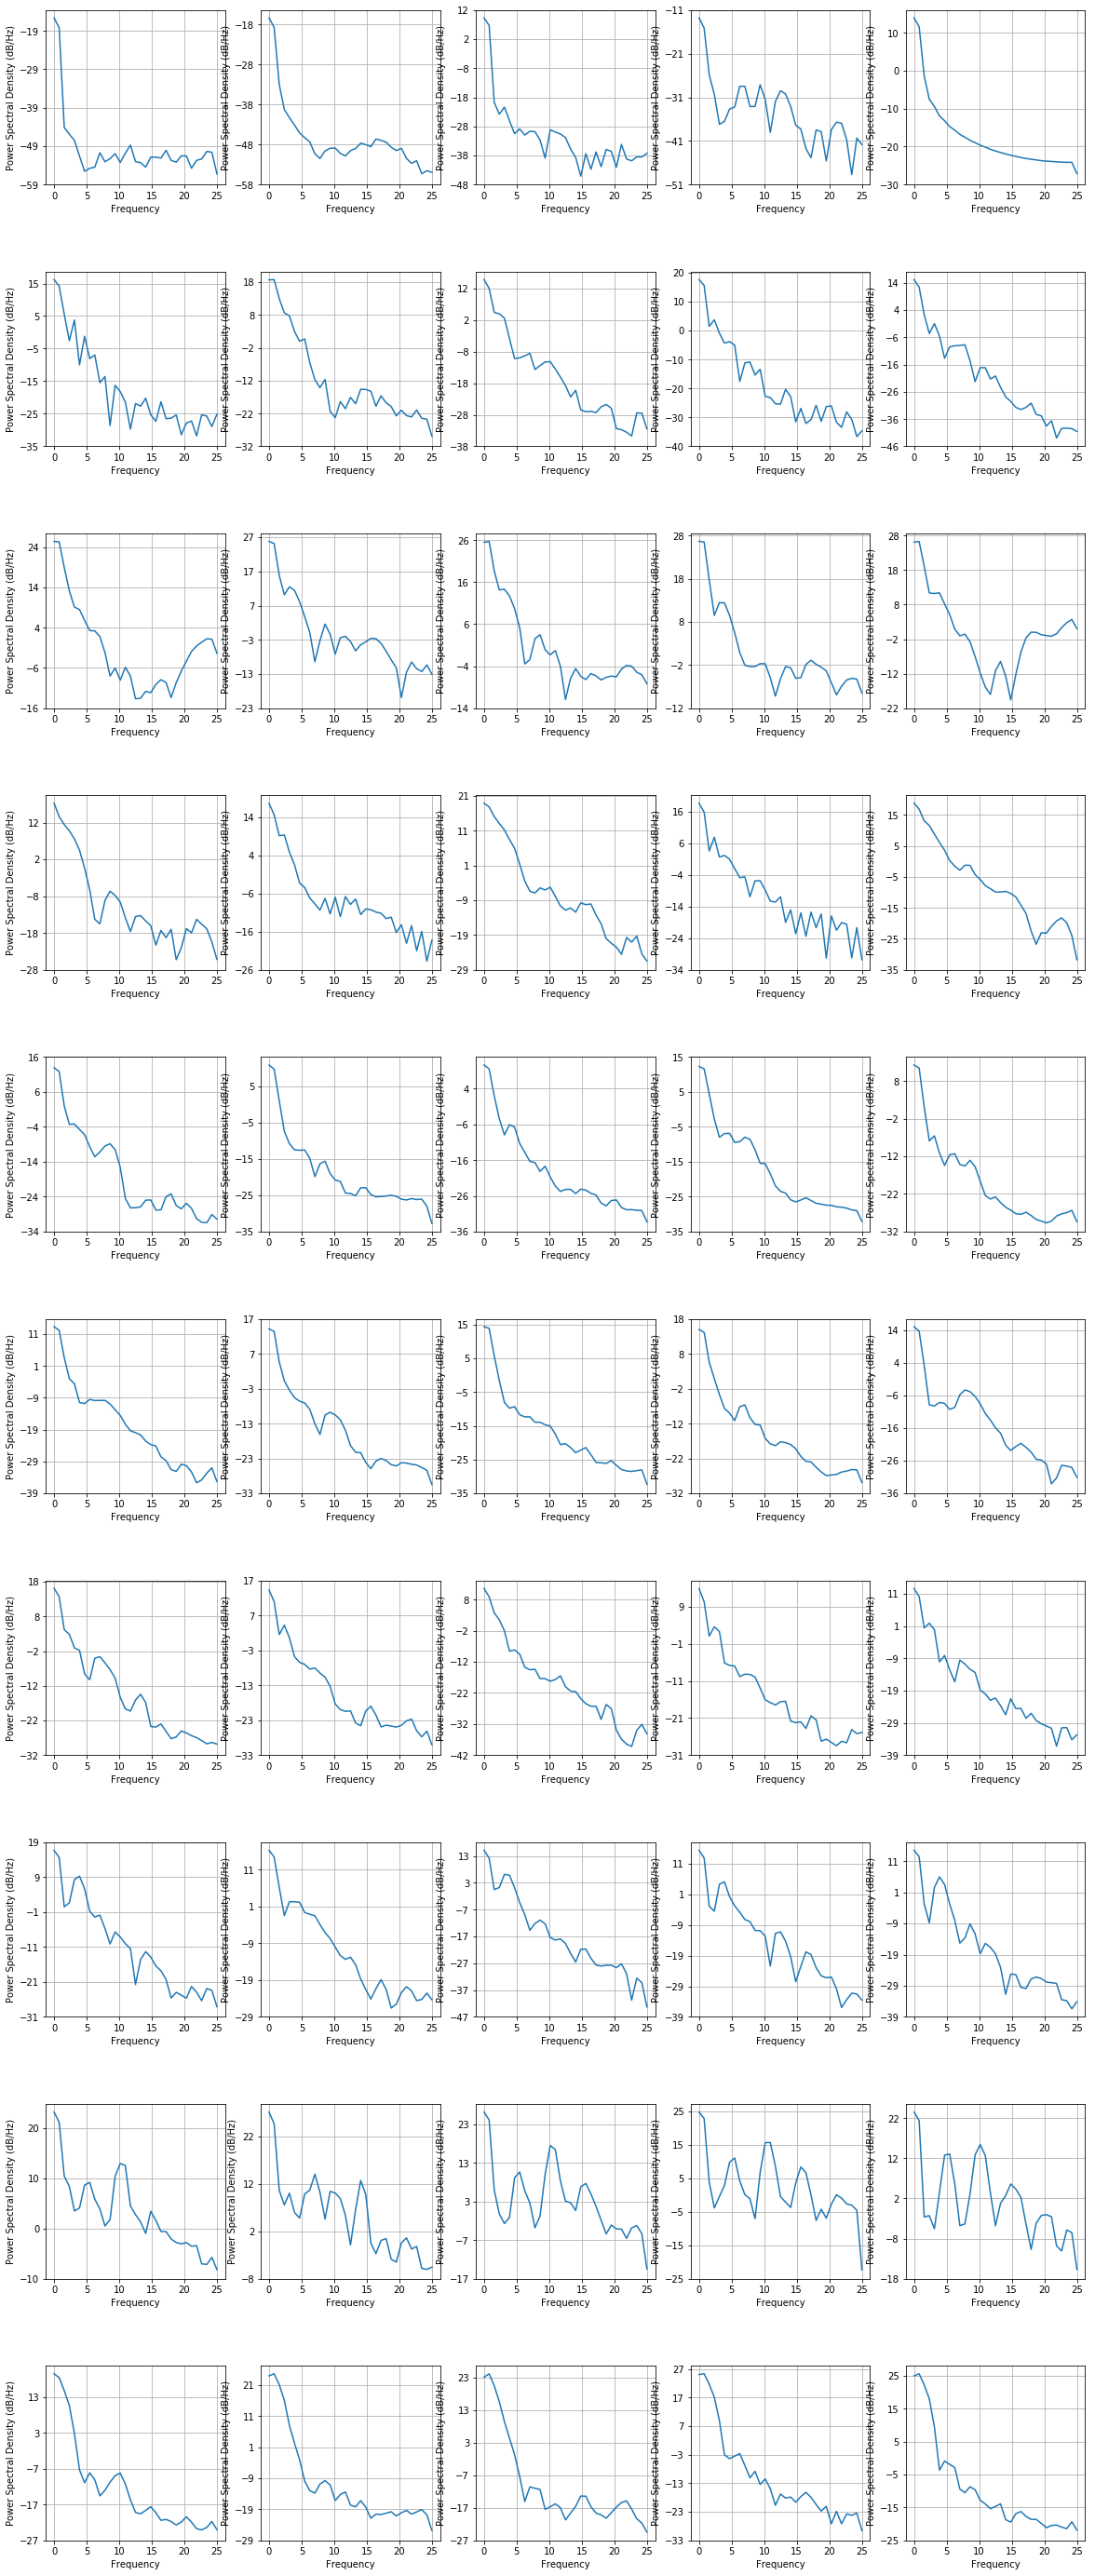

In [15]:
# Do some spectral analysis
from scipy import signal
from matplotlib.pyplot import specgram
from math import floor

fig, axes = plt.subplots(len(mapGestureToTrials), 5, figsize=(20, 5 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    trialNum = 1
    trialIndex = 0
    for trial in gestureTrials:
        lastTimestamp = trial.accel.sensorTimestampNano[len(trial.accel.sensorTimestampNano) - 1]
        firstTimestamp = trial.accel.sensorTimestampNano[0]
        samplingRateInMs = (lastTimestamp - firstTimestamp) / len(trial.accel.sensorTimestampNano)
        samplingRateInSecs =  floor(samplingRateInMs/1000)
        axes[index][trialIndex].psd(trial.accel.mag, NFFT=64, Fs=50, noverlap=16, label="Trial {} of {}".format(trialNum, trial.gestureName))
        trialNum += 1
        trialIndex += 1
        
    index += 1
#plt.specgram(trial.accel.mag, 256,64,0)
plt.show()
plt.clf()

## FastDTW

In [16]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# first we generate our k-fold training and test data, while scaling and detrending
trainTrials = list()
testTrials = list()
index = 0
folds = 5
gestureNamesSorted = sorted(mapGestureToTrials.keys())
gestureSuccessCount = dict()

print("Shuffling, scaling, and detrending data")
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    gestureSuccessCount[gestureName] = 0
    np.random.shuffle(gestureTrials) # shuffle data
    for x in range(0, folds):
        gestureTrials[x].accel.x = scale_and_detrend(gestureTrials[x].accel.x)
        gestureTrials[x].accel.y = scale_and_detrend(gestureTrials[x].accel.y)
        gestureTrials[x].accel.z = scale_and_detrend(gestureTrials[x].accel.z)
        gestureTrials[x].accel.mag = scale_and_detrend(gestureTrials[x].accel.mag)

print("Calculating distances")
# Let's loop through the k-folds, and calculate DTW values to find our best matches
totalSuccess = 0
total = 0
dtwGuess = list()
dtwTrue = list()
for x in range(0, folds):
    print("Running fold {}/{}".format(x + 1, folds))
    testTrials = list()
    trainTrials = list()
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName] 
        for y in range(0, folds):
            if x == y:
                testTrials.append(gestureTrials[y])
            else:
                trainTrials.append(gestureTrials[y])
    for test in testTrials:
        minDist = sys.maxsize
        for train in trainTrials:
            currDist = 0
            distance, path = fastdtw(train.accel.x, test.accel.x, dist=euclidean)
            currDist += distance
            distance, path = fastdtw(train.accel.y, test.accel.y, dist=euclidean)
            currDist += distance
            distance, path = fastdtw(train.accel.z, test.accel.z, dist=euclidean)
            currDist += distance
            distance, path = fastdtw(train.accel.mag, test.accel.mag, dist=euclidean)
            currDist += distance
            if currDist < minDist:
                match = train
                minDist = currDist
        #print(minDist)
        dtwTrue.append(test.gestureName)
        dtwGuess.append(match.gestureName)
        if test.gestureName == match.gestureName:
            gestureSuccessCount[test.gestureName] += 1
            totalSuccess += 1
        total += 1
print("DTW Distance Accuracy: {}/{} ({}%)".format(totalSuccess, total, 100*totalSuccess/total))
for gestureName in gestureNamesSorted:
    print("{} : {}/{} ({}%)".format(gestureName, gestureSuccessCount[gestureName], folds, 100*gestureSuccessCount[gestureName]/folds))

Shuffling, scaling, and detrending data
Calculating distances
Running fold 1/5
Running fold 2/5
Running fold 3/5
Running fold 4/5
Running fold 5/5
DTW Distance Accuracy: 50/50 (100.0%)
At Rest : 5/5 (100.0%)
Backhand Tennis : 5/5 (100.0%)
Baseball Throw : 5/5 (100.0%)
Forehand Tennis : 5/5 (100.0%)
Midair Clockwise O : 5/5 (100.0%)
Midair Counter Clockwise O : 5/5 (100.0%)
Midair S : 5/5 (100.0%)
Midair Zorro Z : 5/5 (100.0%)
Shake : 5/5 (100.0%)
Underhand Bowling : 5/5 (100.0%)


### DTW Confusion Matrix

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


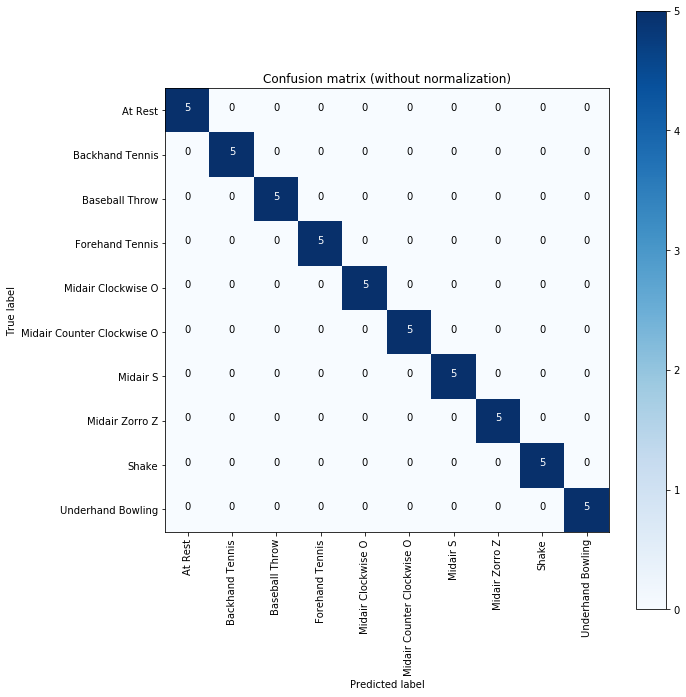

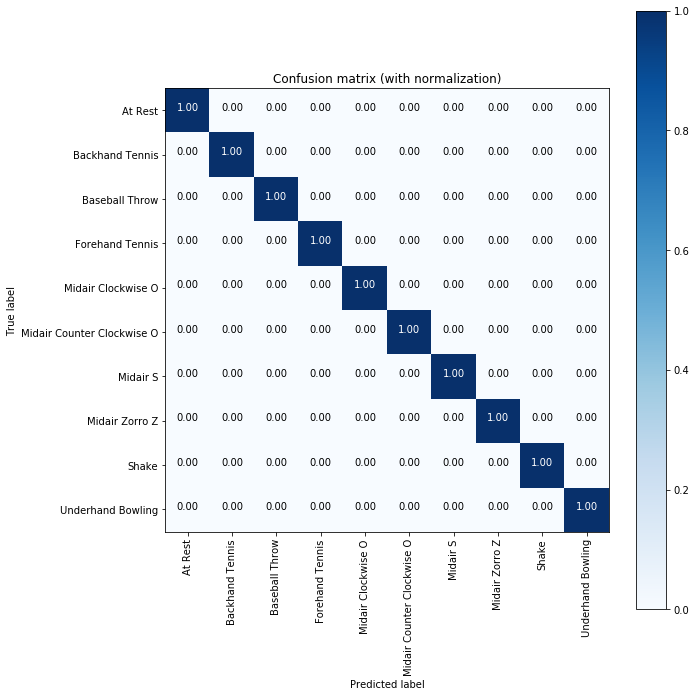

In [17]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(dtwTrue, dtwGuess, gestureNamesSorted)
plt.figure(figsize = (len(gestureNamesSorted), len(gestureNamesSorted)))
plot_confusion_matrix(cm, classes=gestureNamesSorted,
                      title='Confusion matrix (without normalization)')

plt.figure(figsize = (len(gestureNamesSorted), len(gestureNamesSorted)))
plot_confusion_matrix(cm, classes=gestureNamesSorted, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()
plt.clf()

## SVM Classification

In [18]:
# SVM utility functions
def create_feature_vector(trial):
    time = trial.accel.sensorTimestampNano[len(trial.accel.sensorTimestampNano) - 1] - trial.accel.sensorTimestampNano[0]
    retArr = np.array([
        #trial.accel.x.std() + trial.accel.y.std() + trial.accel.z.std(),
        trial.accel.mag.min(),
        trial.accel.mag.mean(),
        trial.accel.mag.max(),
        trial.accel.mag.std(),
        #trial.accel.mag.var(),
        trial.accel.mag.max()/trial.accel.mag.std(),
        #trial.accel.mag.mean()/trial.accel.mag.std(),
        len(np.where(np.diff(np.signbit(trial.accel.mag)))[0]),
        np.argmax(trial.accel.mag),
        np.argmin(trial.accel.mag),
        trial.accel.mag.sum()/time,
        np.abs(trial.accel.mag).sum()/time,
        np.abs(np.fft.fft(trial.accel.mag)).min(),
        np.abs(np.fft.fft(trial.accel.mag)).mean(),
        np.abs(np.fft.fft(trial.accel.mag)).max(),
        np.abs(np.fft.fft(trial.accel.mag)).std(),
        #np.abs(np.fft.fft(trial.accel.mag)).var(),
        trial.accel.x.min(),
        trial.accel.x.mean(),
        trial.accel.x.max(),
        trial.accel.x.std(),
        trial.accel.x.var(),
        trial.accel.x.max()/trial.accel.x.std(),
        #trial.accel.x.mean()/trial.accel.x.std(),
        len(np.where(np.diff(np.signbit(trial.accel.x)))[0]),
        np.argmax(trial.accel.x),
        np.argmin(trial.accel.x),
        trial.accel.x.sum()/time,
        np.abs(trial.accel.mag).sum()/time,
        np.abs(np.fft.fft(trial.accel.x)).min(),
        np.abs(np.fft.fft(trial.accel.x)).mean(),
        np.abs(np.fft.fft(trial.accel.x)).max(),
        np.abs(np.fft.fft(trial.accel.x)).std(),
        #np.abs(np.fft.fft(trial.accel.x)).var(),
        trial.accel.y.min(),
        trial.accel.y.mean(),
        trial.accel.y.max(),
        trial.accel.y.std(),
        #trial.accel.y.var(),
        trial.accel.y.max()/trial.accel.y.std(),
        #trial.accel.y.mean()/trial.accel.y.std(),
        len(np.where(np.diff(np.signbit(trial.accel.y)))[0]),
        np.argmax(trial.accel.y),
        np.argmin(trial.accel.y),
        trial.accel.y.sum()/time,
        np.abs(trial.accel.y).sum()/time,
        np.abs(np.fft.fft(trial.accel.y)).min(),
        np.abs(np.fft.fft(trial.accel.y)).mean(),
        np.abs(np.fft.fft(trial.accel.y)).max(),
        np.abs(np.fft.fft(trial.accel.y)).std(),
        #np.abs(np.fft.fft(trial.accel.y)).var(),
        trial.accel.z.min(),
        trial.accel.z.mean(),
        trial.accel.z.max(),
        trial.accel.z.std(),
        #trial.accel.z.var(),
        trial.accel.z.max()/trial.accel.z.std(),
        #trial.accel.z.mean()/trial.accel.z.std(),
        len(np.where(np.diff(np.signbit(trial.accel.z)))[0]),
        np.argmax(trial.accel.z),
        np.argmin(trial.accel.z),
        trial.accel.z.sum()/time,
        np.abs(trial.accel.z).sum()/time,
        np.abs(np.fft.fft(trial.accel.z)).min(),
        np.abs(np.fft.fft(trial.accel.z)).mean(),
        np.abs(np.fft.fft(trial.accel.z)).max(),
        np.abs(np.fft.fft(trial.accel.z)).std(),
        #np.abs(np.fft.fft(trial.accel.z)).var(),
        trial.gyro.mag.min(),
        trial.gyro.mag.mean(),
        trial.gyro.mag.max(),
        trial.gyro.mag.std(),
        #trial.gyro.mag.var(),
        trial.gyro.mag.max()/trial.gyro.mag.std(),
        np.argmax(trial.gyro.mag),
        np.abs(np.fft.fft(trial.gyro.mag)).min(),
        np.abs(np.fft.fft(trial.gyro.mag)).mean(),
        np.abs(np.fft.fft(trial.gyro.mag)).max(),
        np.abs(np.fft.fft(trial.gyro.mag)).std(),
        #np.abs(np.fft.fft(trial.gyro.mag)).var(),
        trial.gyro.x.min(),
        trial.gyro.x.mean(),
        trial.gyro.x.max(),
        trial.gyro.x.std(),
        #trial.gyro.x.var(),
        trial.gyro.x.max()/trial.gyro.x.std(),
        np.argmax(trial.gyro.x),
        np.abs(np.fft.fft(trial.gyro.x)).min(),
        np.abs(np.fft.fft(trial.gyro.x)).mean(),
        np.abs(np.fft.fft(trial.gyro.x)).max(),
        np.abs(np.fft.fft(trial.gyro.x)).std(),
        #np.abs(np.fft.fft(trial.gyro.x)).var(),
        trial.gyro.y.min(),
        trial.gyro.y.mean(),
        trial.gyro.y.max(),
        trial.gyro.y.std(),
        #trial.gyro.y.var(),
        trial.gyro.y.max()/trial.gyro.y.std(),
        np.argmax(trial.gyro.y),
        np.abs(np.fft.fft(trial.gyro.y)).min(),
        np.abs(np.fft.fft(trial.gyro.y)).mean(),
        np.abs(np.fft.fft(trial.gyro.y)).max(),
        np.abs(np.fft.fft(trial.gyro.y)).std(),
        np.abs(np.fft.fft(trial.gyro.y)).var(),
        trial.gyro.z.min(),
        trial.gyro.z.mean(),
        trial.gyro.z.max(),
        trial.gyro.z.std(),
        #trial.gyro.z.var(),
        trial.gyro.z.max()/trial.gyro.z.std(),
        np.argmax(trial.gyro.z),
        np.abs(np.fft.fft(trial.gyro.z)).min(),
        np.abs(np.fft.fft(trial.gyro.z)).mean(),
        np.abs(np.fft.fft(trial.gyro.z)).max(),
        np.abs(np.fft.fft(trial.gyro.z)).std(),
        #np.abs(np.fft.fft(trial.gyro.z)).var()
    ])
    retArr = np.nan_to_num(retArr)
    return retArr.reshape(1,len(retArr))

# SVM setup
from sklearn import svm

numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mapGestureToTrials)
index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
gestureSuccessCount = dict()
svmGuess = list()
svmTrue = list()
totalSuccess = 0
total = 0

for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    gestureSuccessCount[gestureName] = 0
    np.random.shuffle(gestureTrials) # shuffle data

for x in range(0, numFolds):
    print("Running fold {}/{}".format(x + 1, numFolds))    
    classLabels = np.array([])
    testTrials = list()
    trainingData = np.array([])
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName] 
        for y in range(0, folds):
            if x == y:
                testTrials.append(gestureTrials[y])
            else:
                if trainingData.size == 0:
                    trainingData = create_feature_vector(gestureTrials[y])
                else:
                    trainingData = np.append(trainingData, create_feature_vector(gestureTrials[y]), axis=0)
                classLabels = np.append(classLabels, gestureTrials[y].gestureName)

    # Train SVM
    clf = svm.SVC(kernel='linear')
    clf.fit(trainingData, classLabels) 
    
    for test in testTrials:
        svmPrediction = clf.predict(create_feature_vector(test))[0]
        svmTrue.append(test.gestureName)
        svmGuess.append(svmPrediction)
        #print("{}: {} predicted {}".format(svmPrediction == test.gestureName, test.gestureName, svmPrediction))
        if svmPrediction == test.gestureName:
            gestureSuccessCount[test.gestureName] += 1
            totalSuccess += 1
        total += 1
        
print("SVM Accuracy: {}/{} ({}%)".format(totalSuccess, total, 100*totalSuccess/total))
for gestureName in gestureNamesSorted:
    print("{} : {}/{} ({}%)".format(gestureName, gestureSuccessCount[gestureName], folds, 100*gestureSuccessCount[gestureName]/folds))

Running fold 1/5
Running fold 2/5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


Running fold 3/5
Running fold 4/5
Running fold 5/5
SVM Accuracy: 49/50 (98.0%)
At Rest : 5/5 (100.0%)
Backhand Tennis : 5/5 (100.0%)
Baseball Throw : 5/5 (100.0%)
Forehand Tennis : 5/5 (100.0%)
Midair Clockwise O : 5/5 (100.0%)
Midair Counter Clockwise O : 5/5 (100.0%)
Midair S : 5/5 (100.0%)
Midair Zorro Z : 5/5 (100.0%)
Shake : 4/5 (80.0%)
Underhand Bowling : 5/5 (100.0%)


### SVM Confusion Matrix

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 1 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.2 0.  0.  0.  0.  0.  0.8 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


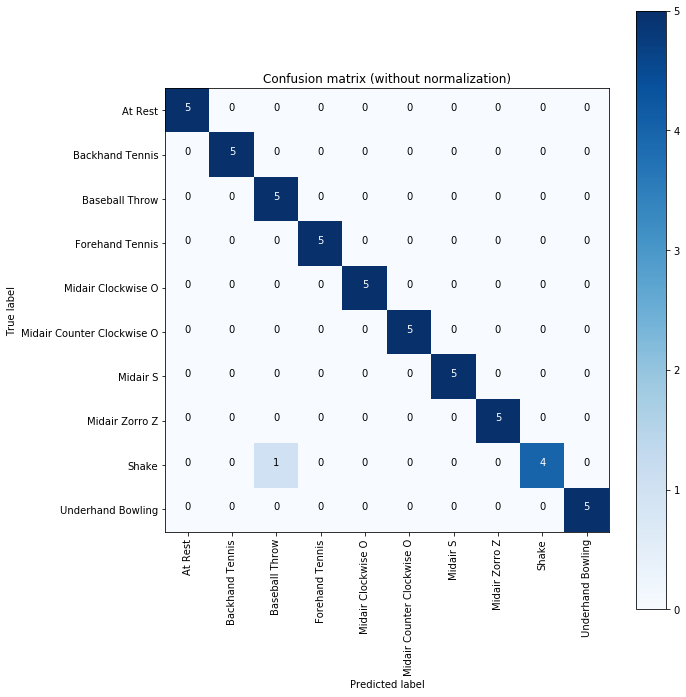

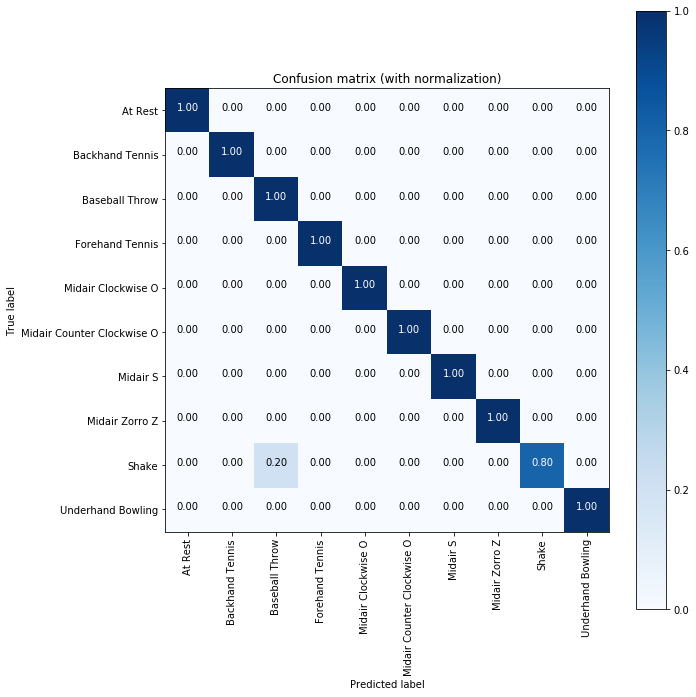

In [19]:
cm = confusion_matrix(svmTrue, svmGuess, gestureNamesSorted)
plt.figure(figsize = (len(gestureNamesSorted), len(gestureNamesSorted)))
plot_confusion_matrix(cm, classes=gestureNamesSorted,
                      title='Confusion matrix (without normalization)')

plt.figure(figsize = (len(gestureNamesSorted), len(gestureNamesSorted)))
plot_confusion_matrix(cm, classes=gestureNamesSorted, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()
plt.clf()

# Sandbox

In [20]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

(array([0, 2], dtype=int64),)
['apple' 'apple']


In [21]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

5
7


{'newVar': 7, 'testVar': 5}

In [22]:
# Experimenting with how folding and unfolding tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
1 2 3 4 5 6 7 8 9 10
6 7 8 9 10


In [23]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

['a', 'c', 'd']
['c', 'd', 'a']
['c', 'a']


In [24]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])

[1, 2, 3, 4]
[1, 2, 3, 5]
[4, 5]
[1, 2, 3]


In [25]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
np2 - np1

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
np3_resized - np2

array([ 0,  0, -1, -5, -5])

In [26]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

6.324555320336759
6.324555320336759


In [27]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
for x in range(0, 5):
    print(x)
c = a + b

fig, axes = plt.subplots()
# axes.plot(a)
# axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()


[22.7578198  44.18298861  9.03906646 32.43673776 14.05076385 23.5618556
 46.10264139 25.22887434 13.34597103 40.73637302 40.07721274  0.1785362
  9.54209541 13.5825408  49.26390948 14.69580428 31.53363728 15.19945283
 15.13518392  8.6010115  34.67424957 25.22420361  1.76030338 48.68504756
 42.88914605 24.23551133  9.3222712   2.14540562 41.96588372 15.84794226
 43.65677022 35.39792304 24.77328843  9.07536489  6.16522236 46.09506411
 12.78572814  3.96064647 39.74192774 15.72035422 36.67333801 18.95833396
 34.78928614 34.63444662 15.14084283 35.10360268 42.32050582  3.5333474
 26.04170858 18.38850317]
0
1
2
3
4


Confusion matrix, without normalization
[[2 0 0]
 [0 1 1]
 [1 0 2]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.5        0.5       ]
 [0.33333333 0.         0.66666667]]


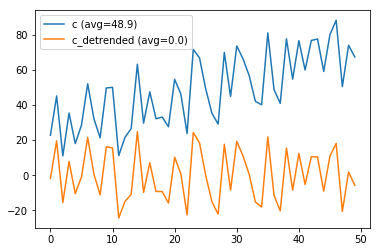

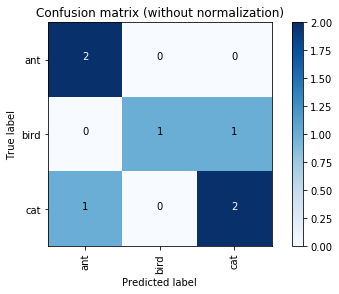

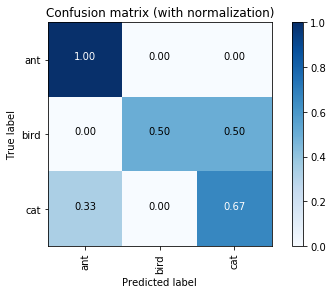

In [28]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()
plt.clf()